In [46]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as plt
import random as rand
from ipywidgets import *
from scipy import stats
import importlib
import sys
sys.path.append(os.getcwd()+'/../')
from utils import utils
from utils import utils, zscores
from utils import plotting_utils as pu
from tqdm import tqdm
import warnings

import cmocean
cmap = cmocean.cm.thermal
colors = cmap

# from utils import auc_methods as ama
# import matplotlib.patches as patches
# from matplotlib import gridspec
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from matplotlib_venn import venn2

%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=14)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
DATA_DIR = os.path.abspath('../data')
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

log_df, unit_key_df = utils.load_data(data_directory, switch=True)
unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size, include_switch = True)
log_df['spike_counts(stim_aligned)'] = log_df[
    'spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)

C:\Users\efink\Documents\Github\crossmodal\Figure4/..\utils\utils.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  licks = licks.applymap(lambda y: y[[0.1<y]] if len(y) > 0 else y)
C:\Users\efink\Documents\Github\crossmodal\Figure4/..\utils\utils.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  licks = licks.applymap(lambda y: y[[3>=y]] if len(y) > 0 else y)


In [51]:
def cacl_mean_diff(labels, values, shuff = True):
    if shuff:
        labels = np.random.permutation(labels)
    
    pos_mean = np.mean(values[labels, :])
    neg_mean = np.mean(values[~labels, :])
#     import pdb;pdb.set_trace()
#     print(pos_mean)
    return pos_mean-neg_mean
                    

def mean_permutation_test(labels, values, num_iter = 1000):
    pos_mean = np.mean(values[labels, :])
    neg_mean = np.mean(values[~labels, :])

    real_value = cacl_mean_diff(labels, values, shuff = False)
    shuff_values = [cacl_mean_diff(labels, values, shuff = True) for i in range(num_iter)]
    p_val = np.mean(shuff_values >= real_value)
    return p_val, real_value, shuff_values


def permutation_test_compare_baseline(unit_key_df, trial_type, time_window, num_iter = 10000):
    
    ## binsize = 0.025, 
    ## stim onset in z-scored trial type arrays start at 1 sec (start of +1sec bin is 39)
    time_wind_inds = ((np.array(time_window)/0.025) + 39).astype(int)
    
    test_period =  np.vstack(unit_key_df[trial_type].values)[:, time_wind_inds[0]:time_wind_inds[1]]
    window_dur = time_wind_inds[1]-time_wind_inds[0]
    baseline_period =  np.vstack(unit_key_df[trial_type].values)[:, 39-window_dur:39]

    pooled_periods = np.vstack([test_period, baseline_period])
    pooled_period_labels = np.concatenate([[True]*test_period.shape[0], [False]*baseline_period.shape[0]])
    
    results = mean_permutation_test(pooled_period_labels,pooled_periods, num_iter = num_iter)
    
    print(f"   mean z-score: {test_period.mean():.3f}, sem: {test_period.std()/np.sqrt(test_period.shape[0]):.2f}")
    print(f"   pval:{results[0]}, test_stat: {results[1]:.2f}, n_iter: {len(results[2])}\n")
    
    return results
     

def permutation_test_compare_trials(unit_key_df, trial_type1, trial_type2, time_window, num_iter = 10000):
    
    ## binsize = 0.025, 
    ## stim onset in z-scored trial type arrays start at 1 sec (start of +1sec bin is 39)
    time_wind_inds = ((np.array(time_window)/0.025) + 39).astype(int)
    
    trial_type1 =  np.vstack(unit_key_df[trial_type1].values)[:, time_wind_inds[0]:time_wind_inds[1]]
    trial_type2 =  np.vstack(unit_key_df[trial_type2].values)[:, time_wind_inds[0]:time_wind_inds[1]]

    pooled_periods = np.vstack([trial_type1, trial_type2])
    pooled_period_labels = np.concatenate([[True]*trial_type1.shape[0], [False]*trial_type2.shape[0]])
    p_val, real_val, shuff_vals = mean_permutation_test(pooled_period_labels,pooled_periods, num_iter = num_iter)
    
    results = mean_permutation_test(pooled_period_labels,pooled_periods, num_iter = num_iter)
    
    print(f"   mean z-score difference: {(trial_type1 - trial_type2).mean():.2f}, sem: {(trial_type1 - trial_type2).std()/np.sqrt(trial_type1.shape[0]):.2f}")
    print(f"   pval:{results[0]}, test_stat: {results[1]:.2f}, n_iter: {len(results[2])}\n")
    return results
    

In [10]:
conds = ['Touch Stim Lick Right', 'Touch Stim Lick Left', 'Touch Stim No Lick', 
         'Visual Stim Lick Right','Visual Stim Lick Left', 'Visual Stim No Lick']
unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window, conds = conds)
unit_key_df = unit_key_df.sort_values(['activation_resp_touch'], ascending = False)

C:\Users\efink\Documents\Github\crossmodal\Figure4/..\utils\zscores.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  bin_means = np.mean(np.stack(cond_rows.as_matrix(), axis = 0), axis=0)


In [11]:
print('hits vs miss 0-500ms')
hit_vs_miss_500ms = permutation_test_compare_trials(unit_key_df, 'Touch Stim Lick Right(z_score)', 'Touch Stim Lick Left(z_score)', [0,0.5])


hits vs miss 0-500ms
   mean z-score difference: 0.19, sem: 0.08
   pval:0.0305, test_stat: 0.19, n_iter: 10000



In [50]:
for t in np.arange(0,0.4,0.025):

    print(f'Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) {t*1000:.0f}-{(t+.15)*1000:.0f}ms')
    hit_vs_miss_500ms = permutation_test_compare_trials(
        unit_key_df, 'Touch Stim Lick Right(z_score)', 'Touch Stim Lick Left(z_score)', [t,t+0.15])


Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 0-150ms
   mean z-score difference: 0.14, sem: 0.07
   pval:0.1359, test_stat: 0.14, n_iter: 10000

Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 25-175ms
   mean z-score difference: 0.22, sem: 0.07
   pval:0.0636, test_stat: 0.22, n_iter: 10000

Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 50-200ms
   mean z-score difference: 0.27, sem: 0.08
   pval:0.0273, test_stat: 0.27, n_iter: 10000

Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 75-225ms
   mean z-score difference: 0.29, sem: 0.08
   pval:0.0107, test_stat: 0.29, n_iter: 10000

Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 100-250ms
   mean z-score difference: 0.30, sem: 0.08
   pval:0.0057, test_stat: 0.30, n_iter: 10000

Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 125-275ms
   mean z-score difference: 0.31, sem: 0.08
   pval:0.0038, test_stat: 0.31, n_iter: 10000

Touch Sti

In [53]:
from scipy.stats import ttest_rel as ttest

def get_mean_vals(unit_key_df, trial_type1, trial_type2, time_window):
    
    time_wind_inds = ((np.array(time_window)/0.025) + 39).astype(int)
    
    trial_type1 =  np.vstack(unit_key_df[trial_type1].values)[:, time_wind_inds[0]:time_wind_inds[1]]
    trial_type2 =  np.vstack(unit_key_df[trial_type2].values)[:, time_wind_inds[0]:time_wind_inds[1]]

    pooled_periods = np.vstack([trial_type1, trial_type2])
    pooled_period_labels = np.concatenate([[True]*trial_type1.shape[0], [False]*trial_type2.shape[0]])
    
    
    pos_means = np.mean(pooled_periods[pooled_period_labels, :], axis =1)
    neg_means = np.mean(pooled_periods[~pooled_period_labels, :], axis = 1)
    
    return pos_means, neg_means

def mean_t_test(labels, values):
    pos_means = np.mean(values[labels, :], axis =1)
    neg_means = np.mean(values[~labels, :], axis = 1)
    return ttest(pos_means, neg_means, alternative = 'greater')

def paired_trial_t_test(unit_key_df, trial_type1, trial_type2, time_window):
     ## binsize = 0.025, 
    ## stim onset in z-scored trial type arrays start at 1 sec (start of +1sec bin is 39)
    time_wind_inds = ((np.array(time_window)/0.025) + 39).astype(int)
    
    trial_type1 =  np.vstack(unit_key_df[trial_type1].values)[:, time_wind_inds[0]:time_wind_inds[1]]
    trial_type2 =  np.vstack(unit_key_df[trial_type2].values)[:, time_wind_inds[0]:time_wind_inds[1]]

    pooled_periods = np.vstack([trial_type1, trial_type2])
    pooled_period_labels = np.concatenate([[True]*trial_type1.shape[0], [False]*trial_type2.shape[0]])
    results = mean_t_test(pooled_period_labels,pooled_periods)
    
    print(f"   mean z-score difference: {(trial_type1 - trial_type2).mean():.2f}, sem: {(trial_type1 - trial_type2).std()/np.sqrt(trial_type1.shape[0]):.2f}")
    print(f"   pval:{results[1]}, test_stat: {results[0]:.2f}\n")


In [34]:
pos, neg = get_mean_vals(unit_key_df, 'Touch Stim Lick Right(z_score)', 'Touch Stim Lick Left(z_score)', [t,t+0.15])

(Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Difference between\nTouch stim lick right(Z-score) & Touch Stim Lick Left(Z-score)'))

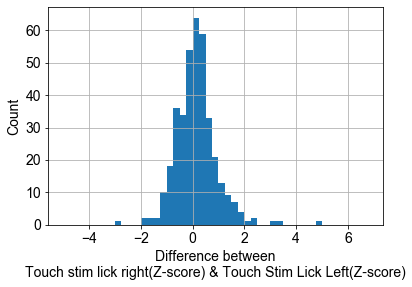

In [49]:
pd.Series(pos-neg).hist(bins = np.arange(-5,7,.25))
ax = plt.gca()

ax.set_ylabel('Count'), ax.set_xlabel('Difference between\nTouch stim lick right(Z-score) & Touch Stim Lick Left(Z-score)')

In [54]:
for t in np.arange(0,0.4,0.025):

    print(f'paired t-test: Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) {t*1000:.0f}-{(t+.15)*1000:.0f}ms')
    hit_vs_miss_500ms = paired_trial_t_test(
        unit_key_df, 'Touch Stim Lick Right(z_score)', 'Touch Stim Lick Left(z_score)', [t,t+0.15])


paired t-test: Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 0-150ms
   mean z-score difference: 0.14, sem: 0.07
   pval:0.00030485481125353323, test_stat: 3.46

paired t-test: Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 25-175ms
   mean z-score difference: 0.22, sem: 0.07
   pval:7.344216704367632e-07, test_stat: 4.89

paired t-test: Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 50-200ms
   mean z-score difference: 0.27, sem: 0.08
   pval:2.1376016595943163e-08, test_stat: 5.59

paired t-test: Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 75-225ms
   mean z-score difference: 0.29, sem: 0.08
   pval:7.743939008460643e-09, test_stat: 5.78

paired t-test: Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 100-250ms
   mean z-score difference: 0.30, sem: 0.08
   pval:8.917793271487312e-09, test_stat: 5.76

paired t-test: Touch Stim Lick Right(z_score) vs Touch Stim Lick Left(z_score) 125-275ms
   mean z